# Importing the libraries

In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import math
import datetime

# Reading the data

In [2]:
urlConfirmed='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
COVID19Series = pd.read_csv(urlConfirmed)

urlDeaths='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
COVID19Deaths= pd.read_csv(urlDeaths)

#Setting to display all contents
pd.set_option('display.max_rows', len(COVID19Series))
pd.set_option('display.max_columns', len(COVID19Series.columns))

# Testing to see if the data has been read

In [3]:
COVID19Series.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3


In [4]:
COVID19Deaths.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,2,2,2,2,2,4,5
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,3,4,4,4,7,9,11,15,17,17,19
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Setting some countries to use the data

In [5]:
Country=COVID19Series['Country/Region']

China = COVID19Series[Country=='China']
Brazil = COVID19Series[Country=='Brazil']
Italy = COVID19Series[Country=='Italy']
UK = COVID19Series[Country=='United Kingdom']
Germany = COVID19Series[Country=='Germany']
France = COVID19Series[Country=='France']
SouthKorea = COVID19Series[Country=='Korea, South']
US = COVID19Series[Country=='Korea, South']
Luxembourg = COVID19Series[Country=='Luxembourg']
Japan = COVID19Series[Country=='Japan']
Spain = COVID19Series[Country=='Spain']

ChinaDeaths = COVID19Deaths[Country=='China']
BrazilDeaths =COVID19Deaths[Country=='Brazil']
ItalyDeaths = COVID19Deaths[Country=='Italy']
UKDeaths = COVID19Deaths[Country=='United Kingdom']
GermanyDeaths = COVID19Deaths[Country=='Germany']
FranceDeaths = COVID19Deaths[Country=='France']
SouthKoreaDeaths = COVID19Deaths[Country=='Korea, South']
USDeaths = COVID19Deaths[Country=='US']
LuxembourgDeaths = COVID19Deaths[Country=='Luxembourg']
JapanDeaths = COVID19Deaths[Country=='Japan']
SpainDeaths = COVID19Deaths[Country=='Spain']

#Testing
SpainDeaths

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20
201,NaN,Spain,40.0,-4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,3,5,10,17,28,35,54,55,133,195,289,342,533,623,830,1043,1375,1772,2311,2808


# Making the graphics 

In [6]:
#Setting some different markers to use in the plots
markerList=['.','d','s','v','^','+','x','8','>','<']

#Setting the countries to plot the confirmed cases along the days 
#due the fact tha markerList has 9 markers we can only use 10 countries or increse the marker List
CountriesList = [Brazil, Italy, UK, Germany, France, SouthKorea,US,Luxembourg,Spain,China]

CountriesListDeaths = [BrazilDeaths, ItalyDeaths, UKDeaths, GermanyDeaths, FranceDeaths, SouthKoreaDeaths,USDeaths,LuxembourgDeaths,SpainDeaths,ChinaDeaths]


#Setting the labels to use
CountryNames=['Brazil','Italy','UK','Germany','France','SouthKorea','US','Luxembourg','Spain','China']

# Bar plot

Country: Confimed Cases, Deaths (deaths/confirmed)



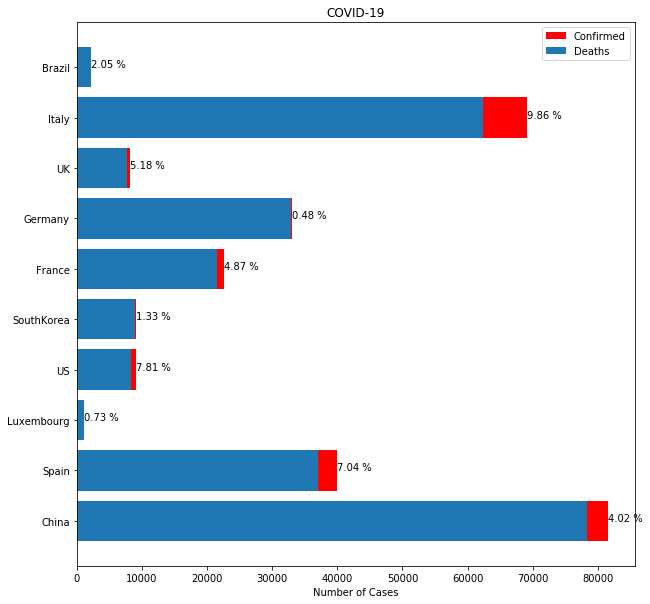

In [7]:
confirmed=[]
deaths=[]


print("Country: Confimed Cases, Deaths (deaths/confirmed)\n")
for i in range(len(CountriesList)):
    confirmed = np.append(confirmed,CountriesList[i].iloc[:,-1].sum())
    deaths = np.append(deaths,CountriesListDeaths[i].iloc[:,-1].sum())    

    
y_pos = np.arange(len(confirmed))
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.barh(y_pos,confirmed, color='r')
ax.barh(y_pos,confirmed-deaths)
ax.legend(labels=['Confirmed', 'Deaths'])
ax.set_yticks(y_pos)
ax.set_yticklabels(CountryNames)
ax.invert_yaxis()

ax.set_xlabel('Number of Cases')
ax.set_title('COVID-19')

for i, (value, name) in enumerate(zip(deaths, CountryNames)):
    ax.text(confirmed[i], i, '%.2f %%' % (deaths[i]/confirmed[i]*100), ha='left')

# Confirmed cases along the days 

Increase or decrease:
Brazil 0.17
Italy 0.08
UK 0.21
Germany 0.14
France 0.12
SouthKorea 0.01
US 0.01
Luxembourg 0.26
Spain 0.14
China 0.00


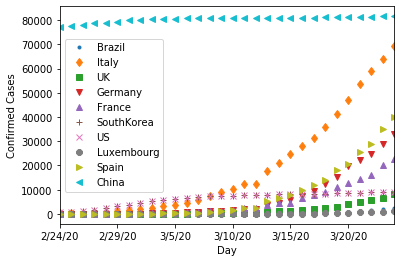

In [8]:
print("Increase or decrease:")
for i in range(len(CountriesList)):
    
    #Shows if the cases has increse or decrease from the last day
    print(CountryNames[i]+' %0.2f' % ((CountriesList[i].iloc[:,-1].sum()-CountriesList[i].iloc[:,-2].sum())/CountriesList[i].iloc[:,-2].sum()))
    
    #plot the curve of the confirmed cases along the days
    country = CountriesList[i].iloc[:,37:].sum()
    country.plot(marker=markerList[i], label=CountryNames[i], ls='none')
    
plt.xlabel('Day')
plt.ylabel('Confirmed Cases')
plt.legend()

#Save the plot in a png format
plt.savefig('ConfirmedCases.png', dpi=300)
plt.show()


# Confirmed cases since the first record in the country

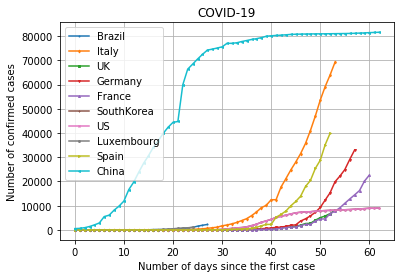

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

for i in range(len(CountriesList)):
    country = CountriesList[i].iloc[:,4:].sum()
    temp = np.array(country.values)
    
    #Set the number of cases to 1
    y_filter = np.where(temp > 0)
    y = temp[y_filter]
    x = np.arange(len(y))
    ax.plot(x, y, marker=markerList[i], markersize=2, ls='-', label=CountryNames[i])


plt.xlabel('Number of days since the first case')
plt.ylabel('Number of confirmed cases')
plt.title('COVID-19')
plt.legend()
plt.grid()
plt.savefig('ConfirmedSinceFirstCase.png', dpi=300)

# Confirmed cases since of the 100 record in the country

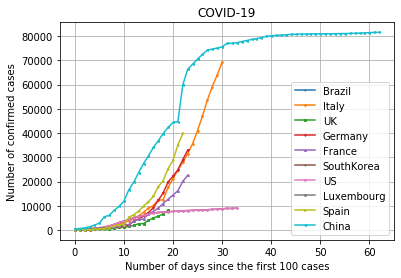

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
#x = np.arange(len(China.iloc[:,4:].sum()))
for i in range(len(CountriesList)):
    country = CountriesList[i].iloc[:,4:].sum()
    temp = np.array(country.values)
    
    #Set the number of cases to 100
    y_filter = np.where(temp > 100)
    y = temp[y_filter]
    x = np.arange(len(y))
    ax.plot(x, y, marker=markerList[i], markersize=2, ls='-', label=CountryNames[i])


plt.xlabel('Number of days since the first 100 cases')
plt.ylabel('Number of confirmed cases')
plt.title('COVID-19')
plt.legend()
plt.grid()
plt.savefig('ConfirmedSince100Cases.png', dpi=300)

# Number of deaths since the first record

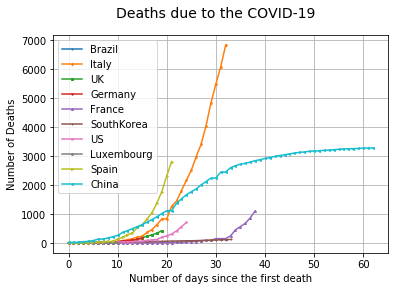

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
#x = np.arange(len(China.iloc[:,4:].sum()))
for i in range(len(CountriesListDeaths)):
    country = CountriesListDeaths[i].iloc[:,4:].sum()
    temp = np.array(country.values)
    
    #Set the first record
    y_filter = np.where(temp > 0)
    y = temp[y_filter]
    x = np.arange(len(y))
    ax.plot(x, y, marker=markerList[i], markersize=2,ls='-', label=CountryNames[i])

fig.suptitle("Deaths due to the COVID-19", fontsize=14)
ax.set(xlabel='Number of days since the first death')
ax.set(ylabel='Number of Deaths')

ax.legend()
ax.grid()

plt.savefig('Deaths.png', dpi=300)

#  Number of deaths since the first record and Logscale

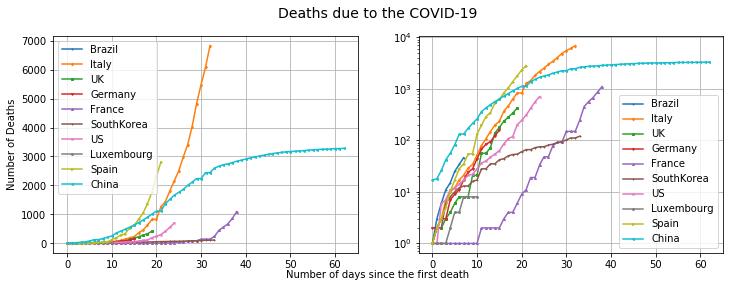

In [12]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 4))
#x = np.arange(len(China.iloc[:,4:].sum()))
for i in range(len(CountriesList)):
    country = CountriesListDeaths[i].iloc[:,4:].sum()
    temp = np.array(country.values)
    y_filter = np.where(temp > 0)
    y = temp[y_filter]
    x = np.arange(len(y))
    ax1.plot(x, y, marker=markerList[i], markersize=2,ls='-', label=CountryNames[i])
    ax2.plot(x, y, marker=markerList[i], markersize=2,ls='-', label=CountryNames[i])
    plt.yscale('log')

    
fig.text(0.5, 0.04, 'Number of days since the first death', ha='center')
fig.suptitle("Deaths due to the COVID-19", fontsize=14)
ax1.set(ylabel='Number of Deaths')
ax1.legend()
ax1.grid()
ax2.legend()
ax2.grid()
plt.savefig('Deaths.png', dpi=300)

# Defining an exponential function to fit the data

In [13]:
def exponenial_func(x, a, b,c):
    return a*np.exp(b*x) + c

# Fitting the data for China, Italy and BraziL

fit 0.152299
fit 0.294454
fit 0.376309


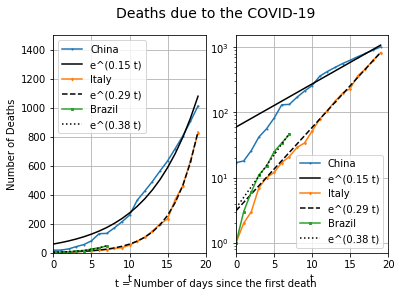

In [14]:
ls=['-','--',':']
NewCountriesList = [ChinaDeaths,ItalyDeaths,BrazilDeaths]
NewCountryNames=['China','Italy','Brazil']

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(6, 4))

for i in range(len(NewCountriesList)):
    country = NewCountriesList[i].iloc[:,4:].sum()
    temp = np.array(country.values)
    y_filter = np.where(temp > 0)
    y = temp[y_filter]
    x = np.arange(len(y))
    
    #taking only the first 20 days
    D=20
   
    xx=x[:D]
    y_=y[:D]
    popt, pcov = curve_fit(exponenial_func, xx, y_, p0=(1, 1, 0), bounds=(0,[np.inf, 2, np.inf]))
    print('fit %f' % popt[1])
    ax1.plot(xx, y_, marker=markerList[i], markersize=2, ls='-', label=NewCountryNames[i])
    ax2.plot(xx, y_, marker=markerList[i], markersize=2, ls='-', label=NewCountryNames[i])
    yy = exponenial_func(xx, *popt)
    ax1.plot(xx,yy, ls=ls[i], label=('e^(%.2f t)'%popt[1]), color='black')
    ax2.plot(xx,yy, ls=ls[i], label=('e^(%.2f t)'%popt[1]), color='black')
    plt.yscale('log')

    
ax1.set(xlabel='t')
ax2.set(xlabel='t')
fig.text(0.5, 0.01, 't = Number of days since the first death', ha='center')
fig.suptitle("Deaths due to the COVID-19", fontsize=14)
ax1.set_xlim([0, D])
ax1.set_ylim([0,1500])
ax1.set(ylabel='Number of Deaths')
ax1.legend()
ax1.grid()
#plt.ylabel('Número de mortos')
#plt.title('Deaths for COVID-19')
#plt.title('Deaths due to the COVID-19')
ax2.set_xlim([0, D])
ax2.legend()
ax2.grid()
plt.savefig('DeathsFit.png', dpi=300)

In [15]:
popt

array([3.41373467e+00, 3.76308888e-01, 4.13464419e-15])

# Prediction of deaths in Brazil

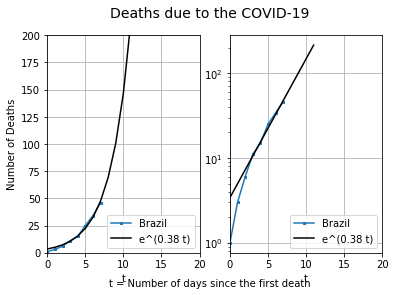

In [16]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(6, 4))

country = BrazilDeaths.iloc[:,4:].sum()
temp = np.array(country.values)
y_filter = np.where(temp > 0)
y = temp[y_filter]
x = np.arange(len(y))

ax1.plot(xx, y_, marker=markerList[i], markersize=2, ls='-', label=NewCountryNames[i])
ax2.plot(xx, y_, marker=markerList[i], markersize=2, ls='-', label=NewCountryNames[i])
x_= np.append(x,[x[-1]+1,x[-1]+2,x[-1]+3,x[-1]+4])
yy = exponenial_func(x_, *popt)
ax1.plot(x_,yy, ls='-', label=('e^(%.2f t)'%popt[1]), color='black')
ax2.plot(x_,yy, ls='-', label=('e^(%.2f t)'%popt[1]), color='black')
plt.yscale('log')

    
ax1.set(xlabel='t')
ax2.set(xlabel='t')
fig.text(0.5, 0.01, 't = Number of days since the first death', ha='center')
fig.suptitle("Deaths due to the COVID-19", fontsize=14)
ax1.set_xlim([0, D])
ax1.set_ylim([0,200])
ax1.set(ylabel='Number of Deaths')
ax1.legend()
ax1.grid()
#plt.ylabel('Número de mortos')
#plt.title('Deaths for COVID-19')
#plt.title('Deaths due to the COVID-19')
ax2.set_xlim([0, D])
ax2.legend()
ax2.grid()
plt.savefig('BrazilFit.png', dpi=300)


China fit 0.152299
time to double the deaths: 4 days 13.2h

Italy fit 0.294454
time to double the deaths: 2 days 8.5h

Brazil fit 0.376309
time to double the deaths: 1 days 20.2h
Number of deads today: 46 | Tomorrow: 69


UK fit 0.256722
time to double the deaths: 2 days 16.8h
Number of deads today: 423 | Tomorrow: 571



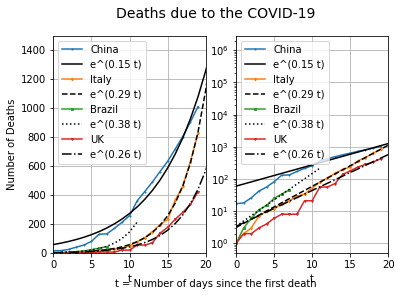

In [17]:
ls=['-','--',':','-.']
NewCountriesList = [ChinaDeaths,ItalyDeaths,BrazilDeaths,UKDeaths]
NewCountryNames=['China','Italy','Brazil','UK']

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(6, 4))

for i in range(len(NewCountriesList)):
    country = NewCountriesList[i].iloc[:,4:].sum()
    temp = np.array(country.values)
    y_filter = np.where(temp > 0)
    y = temp[y_filter]
    x = np.arange(len(y))
    
    #taking only the first D days
    D=20
   
    xx=x[:D]
    y_=y[:D]
    popt, pcov = curve_fit(exponenial_func, xx, y_, p0=(1, 1, 0), bounds=(0,[np.inf, 2, np.inf]))
    
    ax1.plot(xx, y_, marker=markerList[i], markersize=2, ls='-', label=NewCountryNames[i])
    ax2.plot(xx, y_, marker=markerList[i], markersize=2, ls='-', label=NewCountryNames[i])
    
    
    #Prediction for the next 4 days
    xx= np.append(x,[x[-1]+1,x[-1]+2,x[-1]+3,x[-1]+4])
    
    
    yy = exponenial_func(xx, *popt)
    ax1.plot(xx,yy, ls=ls[i], label=('e^(%.2f t)'%popt[1]), color='black')
    ax2.plot(xx,yy, ls=ls[i], label=('e^(%.2f t)'%popt[1]), color='black')
    plt.yscale('log')
    
    days = math.log(2)/popt[1]
    hours = (days - int(days))*24
    print('\n'+NewCountryNames[i]+' fit %f\ntime to double the deaths: %d days %.1fh' 
          % (popt[1], int(days), hours))
    if (NewCountryNames[i] != 'Italy') and (NewCountryNames[i] != 'China') :
        print('Number of deads today: %.0f | Tomorrow: %.0f\n'% (NewCountriesList[i].iloc[:,-1].sum(),yy[-4]))
       
    
ax1.set(xlabel='t\n')
ax2.set(xlabel='t\n')
fig.text(0.5, 0.01, 't = Number of days since the first death', ha='center')
fig.suptitle("Deaths due to the COVID-19", fontsize=14)
ax1.set_xlim([0, D])
ax1.set_ylim([0,1500])
ax1.set(ylabel='Number of Deaths')
ax1.legend()
ax1.grid()
#plt.ylabel('Número de mortos')
#plt.title('Deaths for COVID-19')
#plt.title('Deaths due to the COVID-19')
ax2.set_xlim([0, D])
ax2.legend()
ax2.grid()

